In [1]:
import os
import re
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# 문서 경로 설정
MD_DIR = "../backend/documents/md"

# pyzerox 파일을 제외한 5개 문서 파일 목록
md_files = [
    "국회본회의_회의록._제429회(14차).md",
    "국회본회의_회의록._제429회(15차).md",
    "국회본회의_회의록._제429회(16차).md",
    "국회본회의_회의록._제430회(1차).md",
    "국회본회의_회의록._제430회(2차).md"
]

# Text Splitter 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150,
    separators=["\n\n", "\n", "○"] 
)

def extract_doc_metadata(filename: str) -> dict:
    """파일명에서 문서 메타데이터 추출"""
    pattern = r"제(\d+)회\((\d+)차\)"
    match = re.search(pattern, filename)
    
    session = match.group(1) if match else "unknown"
    meeting = match.group(2) if match else "unknown"
    
    return {
        "source": filename,
        "session": session,
        "meeting": meeting,
        "doc_type": "국회본회의_회의록"
    }

def create_document_header(metadata: dict) -> str:
    """청크 헤더 생성"""
    header = f"""[문서 정보]
- 문서명: {metadata['source']}
- 회기: 제{metadata['session']}회
- 차수: {metadata['meeting']}차
- 유형: {metadata['doc_type']}
---
"""
    return header

def process_all_documents() -> list:
    """모든 문서를 처리하여 하나의 document_list로 반환"""
    all_documents = []
    
    for md_file in md_files:
        file_path = os.path.join(MD_DIR, md_file)
        
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        doc_metadata = extract_doc_metadata(md_file)
        header = create_document_header(doc_metadata)
        chunks = text_splitter.split_text(content)
        
        for i, chunk in enumerate(chunks):
            chunk_with_header = header + chunk
            doc = Document(
                page_content=chunk_with_header,
                metadata={
                    **doc_metadata,
                    "chunk_index": i,
                    "total_chunks": len(chunks)
                }
            )
            all_documents.append(doc)
        
        print(f"처리 완료: {md_file} - {len(chunks)}개 청크 생성")
    
    print(f"\n총 {len(all_documents)}개 Document 생성")
    return all_documents

# 실행
document_list = process_all_documents()

처리 완료: 국회본회의_회의록._제429회(14차).md - 433개 청크 생성
처리 완료: 국회본회의_회의록._제429회(15차).md - 47개 청크 생성
처리 완료: 국회본회의_회의록._제429회(16차).md - 215개 청크 생성
처리 완료: 국회본회의_회의록._제430회(1차).md - 1827개 청크 생성
처리 완료: 국회본회의_회의록._제430회(2차).md - 997개 청크 생성

총 3519개 Document 생성


In [2]:
document_list

[Document(metadata={'source': '국회본회의_회의록._제429회(14차).md', 'session': '429', 'meeting': '14', 'doc_type': '국회본회의_회의록', 'chunk_index': 0, 'total_chunks': 433}, page_content='[문서 정보]\n- 문서명: 국회본회의_회의록._제429회(14차).md\n- 회기: 제429회\n- 차수: 14차\n- 유형: 국회본회의_회의록\n---\n# 국회본회의_회의록._제429회(14차)\n\n> 원본: `국회본회의_회의록._제429회(14차).pdf`\n\n---\n\n\n<!-- Chunk 1/2 -->\n\n\n---\n*제429회-제14차(2025년12월2일) 1*\n\n제429회국회\n(정기회)\n\n\n\n\n## 국 회 본 회 의 회 의 록\n\n\n제 14 호\n\n(임 시 회 의 록)\n\n\n국 회 사 무 처'),
 Document(metadata={'source': '국회본회의_회의록._제429회(14차).md', 'session': '429', 'meeting': '14', 'doc_type': '국회본회의_회의록', 'chunk_index': 1, 'total_chunks': 433}, page_content='[문서 정보]\n- 문서명: 국회본회의_회의록._제429회(14차).md\n- 회기: 제429회\n- 차수: 14차\n- 유형: 국회본회의_회의록\n---\n2025년12월2일(화) 오후 8시 30분\n의사일정\n1. 특정강력범죄의 처벌에 관한 특례법 일부개정법률안(대안)(법제사법위원장 제출)(의안번호\n2214596)\n2. 형법 일부개정법률안(대안)(법제사법위원장 제출)(의안번호 2214597)\n3. 형사소송법 일부개정법률안(대안)(법제사법위원장 제출)(의안번호 2214602)\n4. 형의 집행 및 수용자의 처우에 관한 법률 일부개정법률안(대안)(법제사법위원장 제출)(의안\n번호 2214603)\n5. 전자장치

In [3]:
from langchain_upstage import UpstageEmbeddings
from langchain_chroma import Chroma

embeddings = UpstageEmbeddings(model = "solar-embedding-1-large-query")

vector_store = Chroma(    
    embedding_function=embeddings,
    collection_name="parliament_records",
    persist_directory="../backend/vector_store"
)

In [4]:
retriever = vector_store.as_retriever(search_kwargs={"k": 15})

In [5]:
query = "한지아 의원'이 대표발의한 법안의 내용은?"

In [6]:
retriever.invoke(query)

[Document(id='d8562dee-762a-44c7-8567-af500ea3b517', metadata={'chunk_index': 420, 'session': '429', 'total_chunks': 433, 'doc_type': '국회본회의_회의록', 'meeting': '14', 'source': '국회본회의_회의록._제429회(14차).md'}, page_content='[문서 정보]\n- 문서명: 국회본회의_회의록._제429회(14차).md\n- 회기: 제429회\n- 차수: 14차\n- 유형: 국회본회의_회의록\n---\n---\n*174 제429회-제14차(2025년12월2일)*\n\n\n## (2025. 11. 4. 김원이 의원 대표발의)(의안번호 2213909)\n\n\n\n## 산업 디지털 전환 촉진법 일부개정법률안\n\n\n(2025. 8. 6. 김원이 의원 대표발의)(의안번호 2212017)\n\n\n산업 디지털 전환 촉진법 일부개정법률안\n\n\n(2025. 8. 11. 박성민 의원 대표발의)(의안번호 2212087)\n\n\n폐광지역 개발 지원에 관한 특별법 일부개정법률안\n\n\n(2025. 10. 1. 이철규 의원 대표발의)(의안번호 2213413)\n\n\n폐광지역 개발 지원에 관한 특별법 일부개정법률안\n\n\n(2025. 10. 16. 이철규 의원 대표발의)(의안번호 2213622)\n\n\n(이상 33건 본회의에 부의하지 아니하고 이에 대한 대안 제출)\n이상 40건 산업통상자원중소벤처기업위원장 보고\n\n\n\n장애인복지법 일부개정법률안\n\n\n(2024. 9. 23. 이수진 의원 대표발의)(의안번호 2204168)\n\n\n아동복지법 일부개정법률안\n\n\n(2024. 8. 27. 김미애 의원 대표발의)(의안번호 2203223)\n\n\n의료기사 등에 관한 법률 일부개정법률안\n\n\n(2025. 2. 27. 남인순 의원 대표발의)(의안번호 2208530)\n\n\n검역법 일부개정법률안\n\n\n(2025. 3.

In [7]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


In [8]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)


In [9]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    
    return {'context': docs}


In [10]:
from langchain_classic import hub
from langchain_upstage import ChatUpstage
prompt = hub.pull("rlm/rag-prompt")
llm = ChatUpstage()

In [11]:
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    rag_chain = prompt | llm
    response = rag_chain.invoke({
        'context': context,
        'question': query
    })
    return {'answer': response}

In [12]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [13]:
from langgraph.graph import END, START

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve','generate')
graph_builder.add_edge('generate', END)

In [14]:
graph = graph_builder.compile()

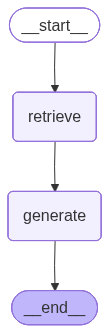

In [15]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_state = {'query': "쿠팡 개인정보관련하여 어떻게 됐어"}
graph.invoke(initial_state)

{'query': '쿠팡 개인정보관련하여 어떻게 됐어',
 'context': [Document(id='507a5cdb-5b83-413f-b0e2-a980c43d2559', metadata={'doc_type': '국회본회의_회의록', 'chunk_index': 1706, 'total_chunks': 1827, 'session': '430', 'source': '국회본회의_회의록._제430회(1차).md', 'meeting': '1'}, page_content='[문서 정보]\n- 문서명: 국회본회의_회의록._제430회(1차).md\n- 회기: 제430회\n- 차수: 1차\n- 유형: 국회본회의_회의록\n---\n---\n*846 제430회-제1차(2025년12월14일)*\n\n그리고 그 진실은 아직 수사 중이겠으나 SK텔레콤, KT, 행안부, 쿠팡까지 대한민국의\n개인정보가 다 해킹당하지 않았습니까? KT도 KT의 펨토셀 장비를 가지고 KT를 해킹\n한 사람, 그 팀에도 중국인 국적이 있습니다. 그리고 이번에 쿠팡에서 개인정보를 탈취해\n간 직원도 중국 국적이었다고 합니다. 국민들이 불안하지 않겠습니까?\n\n\n\n\n\n그리고 이제 제가 주제를 옮겨 갈 미중 갈등의 밑그림 속에서 보면 중국·러시아·북한\n이 밀착하고 있고 한국·일본·미국은 동맹을 강화해 가는 추세입니다. 그래서 꼼짝 못 하\n시고 3500억 불 투자 합의도 하신 것 아닙니까? 저는 그 금액이 도저히, 너무 많다고 생\n각합니다. 일본이 한 방식 자체가 잘못됐는데 일본의 방식을 그대로 따라하고 경제 규모\n에 비해서는 우리의 출혈이 더 크고. 진보진영이 집권했지만 현실은 냉엄하기 때문에 미\n국에 맞췄다고 저는 생각합니다. 미국에 맞춘 건 잘하셨습니다. 그런데 출혈이 너무 셉니\n다. 금액이 너무 높습니다.\n\n\n\n\n\n\n\n\n어쨌건 이게 우리의 현실 아니겠습니까? 진보가 집권하든 보수가 집권하든 국가의 안\n정과 후손들의 번영 이게 제일 중요한 것 아니겠습니까? 그것을 위해서 